In [1]:
#Libraries
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, Image
import os
import numpy as np
from openpyxl import Workbook
from skimage import measure
from scipy import stats

**TOTAL FLOORPLANS AVAILABLE**

In [2]:
folder_path = "/kaggle/input/floorplan-dataset-zip/floorplan_dataset" 
files = os.listdir(folder_path)
print("Total Floorplans Available:",len(files))

Total Floorplans Available: 80788


**VISUALIZATION**

Shape: (256, 256, 3)


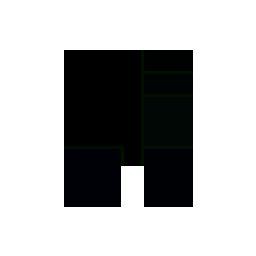

In [3]:
img_path='/kaggle/input/floorplan-dataset-zip/floorplan_dataset/10.png'
img=cv2.imread(img_path)
print("Shape:",img.shape)
display(Image(filename=img_path))

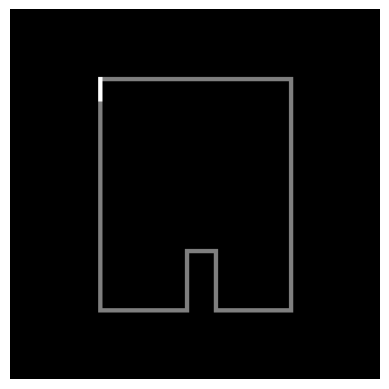

In [4]:
#Exterior wall 127
#Front door 255
#Other 0
plt.imshow(img[:,:,2],cmap='gray')
plt.axis('off')
plt.show()

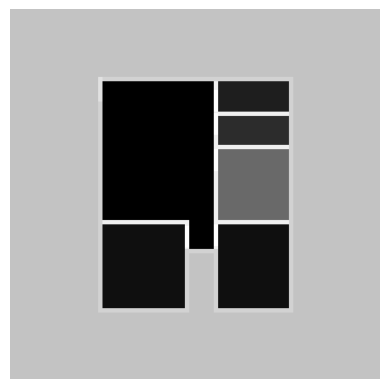

In [5]:
# 0: "Living room",
# 1: "Master room",
# 2: "Kitchen",
# 3: "Bathroom",
# 4: "Dining room",
# 5: "Child room",
# 6: "Study room",
# 7: "Second room",
# 8: "Guest room",
# 9: "Balcony",
# 10: "Entrance",
# 11: "Storage",
# 12: "Wall-in",
# 13: "External area",
# 14: "Exterior wall",
# 15: "Front door",
# 16: "Interior wall",
# 17: "Interior door"
plt.imshow(img[:,:,1],cmap='gray')
plt.axis('off')
plt.show()

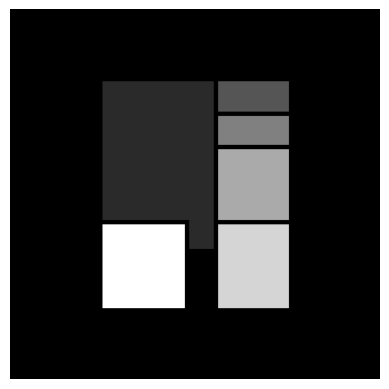

In [6]:
#Different integers are used to distinguish different rooms (starting from 1 and 0 for the non-room area)	
plt.imshow(img[:,:,0],cmap='gray')
plt.axis('off')
plt.show()

**LABELING CONNECTED COMPONENTS AND REGION PROPERTIES**

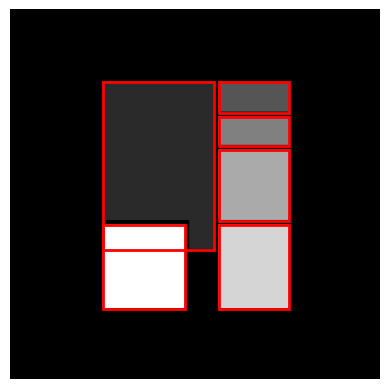

In [9]:
category=img[:,:,0]
diffRooms=img[:,:,1]
_rooms=None

regions=measure.regionprops(category)
rooms = {}

fig, ax = plt.subplots()
ax.imshow(category, cmap='gray')
for region in regions:
    c = stats.mode(
        diffRooms[region.coords[:, 0],
                      region.coords[:, 1]],
        axis=None
    ).mode
    y0, x0, y1, x1 = np.array(region.bbox)
    if c in rooms:
        rooms[c].append([y0, x0, y1, x1])
    else:
        rooms[c] = [[y0, x0, y1, x1]]

for color, bounding_boxes in rooms.items():
    for bbox in bounding_boxes:
        y0, x0, y1, x1 = bbox
        rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

plt.axis('off')
plt.show()

**COMPUTING AREA OF EACH ROOM FROM FLOORPLANS**

In [ ]:
total_plot_size_meters = 18  
total_image_size_pixels = 256  

conversion_factor = total_plot_size_meters / total_image_size_pixels

wb = Workbook()
ws = wb.active

headers = ['Image ID'] + [f'Room {i} Area (sq. meters)' for i in range(10)]
ws.append(headers)

for i in range(80788):
    filename = f"{i}.png"
    image_path = os.path.join('/kaggle/input/floorplan-dataset-zip/floorplan_dataset', filename)

    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        room_areas = {i: 0 for i in range(11)}
        room_areas[0] = i
        
        category=img[:,:,0]
        diffRooms=img[:,:,1]
        regions=measure.regionprops(category)
        row_data = []
        
        for region in regions:
            c = stats.mode(diffRooms[region.coords[:, 0],region.coords[:, 1]],axis=None).mode
            if c<10:
                room_mask = (diffRooms[region.coords[:, 0],region.coords[:, 1]] == c).astype(np.uint8)
                area_pixels = np.sum(room_mask)
                area_meters = area_pixels * conversion_factor**2
                room_areas[c+1] = min(room_areas[c+1], area_meters) if room_areas[c+1] != 0 else area_meters
        for room_area in room_areas.values():
            row_data.append(room_area)
        ws.append(row_data)
#print(room_areas)

excel_path = '/kaggle/working/room_areas.xlsx'
wb.save(excel_path)

**COMPUTING MINIMUM WIDTH OF EACH ROOM FROM FLOORPLANS**

In [ ]:
wb = Workbook()
ws = wb.active

headers = ['Image ID'] + [f'Room {i} minW (meters)' for i in range(10)]
ws.append(headers)

for i in range(80788):
    filename = f"{i}.png"
    image_path = os.path.join('/kaggle/input/floorplan-dataset-zip/floorplan_dataset', filename)

    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        category = img[:,:,0]
        diffRooms=img[:,:,1]
        _rooms = None
        regions = measure.regionprops(category)
        rooms = []
        
        for region in regions:
            c = stats.mode(diffRooms[region.coords[:, 0], region.coords[:, 1]], axis=None).mode
            if c < 10:
                y0, x0, y1, x1 = np.array(region.bbox)
                rooms.append([y0, x0, y1, x1, c])
        
        _rooms = np.array(rooms, dtype=int)
        
        room_w = {i: 0 for i in range(11)}
        room_w[0] = i
        
        for room in _rooms:
            c=room[-1]
            bounding_box=room[0:4]
            width = bounding_box[3] - bounding_box[1]
            height = bounding_box[2] - bounding_box[0]

            min_width_meters = min(width, height) * conversion_factor
            room_w[c+1] = min(room_w[c+1], min_width_meters) if room_w[c+1] != 0 else min_width_meters
        
        width_data=[]
        for wid in room_w.values():
            width_data.append(wid)
        ws.append(width_data)
        #print(width_data)

excel_path = '/kaggle/working/room_minW.xlsx'
wb.save(excel_path)

**PREPROCESSING**

In [3]:
roomIDs=np.load('/kaggle/input/validroomindices/ValidRoomIndices.npy',allow_pickle=True)
print(roomIDs.shape)
roomIDs

(13315,)


array([    2,     4,     9, ..., 80747, 80779, 80782], dtype=int32)

In [4]:
extracted_data=[]
max_categories=9 
for i in range(80788):
    layout_data=np.zeros((max_categories,5),dtype='float')
    layout_data[:,0]=1
    filename=str(i)+'.png'
    image_path=os.path.join('/kaggle/input/floorplan-dataset-zip/floorplan_dataset',filename)
    if os.path.exists(image_path):
        img=cv2.imread(image_path)
        category=img[:,:,0]
        diffRooms=img[:,:,1]
        _rooms=None
        regions=measure.regionprops(category)
        rooms=[]
        for region in regions:
            c = stats.mode(diffRooms[region.coords[:, 0],region.coords[:, 1]],axis=None).mode
            if c<10:
                y0, x0, y1, x1 = np.array(region.bbox)
                rooms.append([y0, x0, y1, x1, c+2])
        _rooms = np.array(rooms, dtype=int)
        category_index = 0
        for room in _rooms:
            category = room[-1]
            bounding_box = room[0:4]

            bottom_right_y, bottom_right_x = bounding_box[-2:]
            width = bottom_right_x - bounding_box[1]
            height = bottom_right_y - bounding_box[0]
            bounding_box_scaled = [bounding_box[1]/256.0, bounding_box[0]/256.0, width/256.0, height/256.0]
            
            row = [category] + list(bounding_box_scaled)
            layout_data[category_index] = np.array(row, dtype=float)
            category_index+=1
    else:
      print(i," not present")
    extracted_data.append(layout_data)
numpy_array = np.array(extracted_data)
#print(numpy_array)
np.save("/kaggle/working/ValidRoomIdsnumpy.npy",numpy_array)

In [17]:
np.save("/kaggle/working/ValidRoomIdsnumpyNEW.npy",numpy_array)

In [5]:
ValidRoomIdsnumpy=np.load('/kaggle/working/ValidRoomIdsnumpy.npy',allow_pickle=True)
print(ValidRoomIdsnumpy.shape)
ValidRoomIdsnumpy[0]

(80788, 9, 5)


array([[ 3.        ,  0.28125   ,  0.62890625,  0.20703125,  0.234375  ],
       [ 5.        ,  0.28125   ,  0.5078125 ,  0.140625  ,  0.109375  ],
       [ 2.        ,  0.43359375,  0.109375  ,  0.2890625 ,  0.6875    ],
       [ 9.        ,  0.28125   ,  0.33984375,  0.20703125,  0.15625   ],
       [ 4.        ,  0.44921875,  0.20703125,  0.1171875 ,  0.12109375],
       [11.        ,  0.5       ,  0.80859375,  0.22265625,  0.0859375 ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [6]:
n_row=32
n_col=32
ValidRoomIdsnumpy[:,:,1] = ValidRoomIdsnumpy[:,:,1]*(n_col-1)
ValidRoomIdsnumpy[:,:,2] = ValidRoomIdsnumpy[:,:,2]*(n_row-1)
ValidRoomIdsnumpy[:,:,3] = ValidRoomIdsnumpy[:,:,3]*(n_col-1)
ValidRoomIdsnumpy[:,:,4] = ValidRoomIdsnumpy[:,:,4]*(n_row-1)
ValidRoomIdsnumpy[0]

array([[ 3.        ,  8.71875   , 19.49609375,  6.41796875,  7.265625  ],
       [ 5.        ,  8.71875   , 15.7421875 ,  4.359375  ,  3.390625  ],
       [ 2.        , 13.44140625,  3.390625  ,  8.9609375 , 21.3125    ],
       [ 9.        ,  8.71875   , 10.53515625,  6.41796875,  4.84375   ],
       [ 4.        , 13.92578125,  6.41796875,  3.6328125 ,  3.75390625],
       [11.        , 15.5       , 25.06640625,  6.90234375,  2.6640625 ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [7]:
for i in range(ValidRoomIdsnumpy.shape[0]): 
    room_num = ValidRoomIdsnumpy[i].shape[0] 
    c=0
    for j in ValidRoomIdsnumpy[i]: 
        if j[3]==0 and j[4]==0:
            break
        c = c+1
    #print(c)
    width1=list(ValidRoomIdsnumpy[i][0:c,3].argsort())
    width2=range(c,room_num)
    order = [*width1,*width2]
    ValidRoomIdsnumpy[i] = np.array(ValidRoomIdsnumpy[i,order])
                
    height1=list(ValidRoomIdsnumpy[i][0:c,4].argsort())
    height2=range(c,room_num)
    order = [*height1,*height2] 
    ValidRoomIdsnumpy[i] = np.array(ValidRoomIdsnumpy[i,order])
                
    xpos1=list(ValidRoomIdsnumpy[i][0:c,1].argsort())
    xpos2=range(c,room_num)
    order = [*xpos1,*xpos2] 
    ValidRoomIdsnumpy[i] = np.array(ValidRoomIdsnumpy[i,order])
                
    ypos1=list(ValidRoomIdsnumpy[i][0:c,2].argsort())
    ypos2=range(c,room_num)
    order = [*ypos1,*ypos2] 
    ValidRoomIdsnumpy[i] = np.array(ValidRoomIdsnumpy[i,order])
ValidRoomIdsnumpy = ValidRoomIdsnumpy

In [8]:
ValidRoomIdsnumpy[0]

array([[ 2.        , 13.44140625,  3.390625  ,  8.9609375 , 21.3125    ],
       [ 4.        , 13.92578125,  6.41796875,  3.6328125 ,  3.75390625],
       [ 9.        ,  8.71875   , 10.53515625,  6.41796875,  4.84375   ],
       [ 5.        ,  8.71875   , 15.7421875 ,  4.359375  ,  3.390625  ],
       [ 3.        ,  8.71875   , 19.49609375,  6.41796875,  7.265625  ],
       [11.        , 15.5       , 25.06640625,  6.90234375,  2.6640625 ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [9]:
n_anchors=(n_row,n_col)
n_classes=11+2
input_dim = n_classes+2*(n_anchors[0]+n_anchors[1])
ValidRoomIdsnumpy=np.array(ValidRoomIdsnumpy,dtype='int')
print(ValidRoomIdsnumpy[0])
print(input_dim)

[[ 2 13  3  8 21]
 [ 4 13  6  3  3]
 [ 9  8 10  6  4]
 [ 5  8 15  4  3]
 [ 3  8 19  6  7]
 [11 15 25  6  2]
 [ 1  0  0  0  0]
 [ 1  0  0  0  0]
 [ 1  0  0  0  0]]
141


In [10]:
onehot_data = []

for layout in ValidRoomIdsnumpy:
    cur_layout = []
    for box in layout:
        temp_one_hot = list(np.zeros(input_dim))
        temp_one_hot[box[0]] = 1
        temp_one_hot[box[1]+n_classes] = 1
        temp_one_hot[box[2]+n_classes+n_col] = 1
        temp_one_hot[box[3]+n_classes+n_col+n_row] = 1
        temp_one_hot[box[4]+n_classes+n_col*2+n_row] = 1
        cur_layout.append(temp_one_hot)
    onehot_data.append(cur_layout)

onehot_data = np.array(onehot_data, dtype='int')
print(onehot_data.shape)

(80788, 9, 141)


In [11]:
onehot_data=np.array(onehot_data,dtype='float32')
print(onehot_data[0][2])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
x_data = []
y_data = []
e=0.1

for layout in onehot_data:
    bos = list(np.zeros(input_dim))
    bos[0]=1
    x = [bos,*layout]
    x = np.array(x).T
    x_data.append(x)

    eos = list(np.zeros(input_dim))
    eos[n_classes-1] = 1
    y = [*layout,eos]
    
    for box in y:
        for k in range(0, n_classes):
            box[k] = (1 - e) * box[k] + e / n_classes
        for k in range(n_classes, n_classes+n_col):
            box[k] = (1 - e) * box[k] + e / n_col
            
        for k in range(n_classes+n_col, n_classes+n_col+n_row):
            box[k] = (1 - e) * box[k] + e / n_row
            
        for k in range(n_classes+n_col+n_row, n_classes+2*n_col+n_row):
            box[k] = (1 - e) * box[k] + e / n_col
            
        for k in range(n_classes+2*n_col+n_row, n_classes+2*n_col+2*n_row):
            box[k] = (1 - e) * box[k] + e / n_row

    y = np.array(y).T
    y_data.append(y)

x_data = np.array(x_data,dtype="float32")
y_data = np.array(y_data,dtype="float32")

In [13]:
print(x_data.shape)
print(y_data.shape)

(80788, 141, 10)
(80788, 141, 10)


In [14]:
y_data[0,:,0]

array([0.00769231, 0.00769231, 0.9076923 , 0.00769231, 0.00769231,
       0.00769231, 0.00769231, 0.00769231, 0.00769231, 0.00769231,
       0.00769231, 0.00769231, 0.00769231, 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.903125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.903125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.00312

In [15]:
np.save('/kaggle/working/x_data.npy',x_data)
np.save('/kaggle/working/y_data.npy',y_data)